In [1]:
# The goal of this nb is to create a ML model to predict the expected loss (for the insurance company) given an individual and their subsequent characteristics such as age, sex, smoking, etc. 

# ExpAmt fields – these values represent the expected claim amounts for the policy year based upon certain mortality tables (such as the 2015 vbt, for example).
    # The values depend upon various factors such as issue age, sex, smoker/non-smoker, and duration.
    # For example, suppose we had a policy issued on a 20-year-old male non-smoker that is now in its 10th policy year (duration = 10, and the insured is now 30 years old).
    # According to the 2015 vbt table, the expected death rate for such a person is 0.44 per 1000; said differently, you could say that such an individual has a 0.44/1000 = 0.00044 probability of dying that year.
    # If the policy were for 500,000, then our expected claim amount for the policy year would be 500,000 * 0.44 / 1000 = 220.
    # As you might expect, older individuals will typically have a higher probability of dying and thus higher expected claim amounts for the same policy size.
    # Similarly, different smoker status and/or sex will affect the expected claim amounts.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats

In [13]:
# Bring in Data and Select Input and Output variable(s)

df = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')

df = df.drop_duplicates()

X = df[['CvgSexCode',
        'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'MortExposureAmt',
        'PivotTobaccoCode',
        '2015vbtExpAmt',
        '2015vbtExpNum'
        ]]


C:\Users\oakle\AppData\Local\Temp\ipykernel_14924\1017768119.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')


In [14]:
X.reset_index(inplace=True,drop=True)

for row in X.itertuples():


    index = row[0]
    
    # Convert sex_char to num
    gender = row.CvgSexCode
    if gender == 'M':
        X.at[index,'CvgSexCode'] = 0
    else: X.at[index,'CvgSexCode'] = 1

    # Convert smoker to num
    smoker = str(getattr(row,'PivotTobaccoCode'))
    if smoker == 'S':
        X.at[index,'PivotTobaccoCode'] = 1
    else: X.at[index,'PivotTobaccoCode'] = 0


In [15]:

y = df['MortDecAmt']
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
810553    0.0
810554    0.0
810555    0.0
810556    0.0
810557    0.0
Name: MortDecAmt, Length: 810558, dtype: float64

In [16]:
X

# Perform a cube root transformation on 'MortExposureAmt', '2015vbtExpAmt', and '2015vbtExpNum'
X['MortExposureAmt'] = X['MortExposureAmt']**(1/3)
X['2015vbtExpAmt'] = X['2015vbtExpAmt']**(1/3)
X['2015vbtExpNum'] = X['2015vbtExpNum']**(1/3)
y = y**(1/3)

C:\Users\oakle\AppData\Local\Temp\ipykernel_14924\1987301247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['MortExposureAmt'] = X['MortExposureAmt']**(1/3)
C:\Users\oakle\AppData\Local\Temp\ipykernel_14924\1987301247.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['2015vbtExpAmt'] = X['2015vbtExpAmt']**(1/3)
C:\Users\oakle\AppData\Local\Temp\ipykernel_14924\1987301247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [17]:
# Designate 80% of Data for training the model and 20% for Testing/Validation
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.8,test_size=.2,random_state=50)

# ------------------- FROM THIS POINT ON ALL TRAIN AND TEST DATA MUST BE SEPARATE. --------------------------------

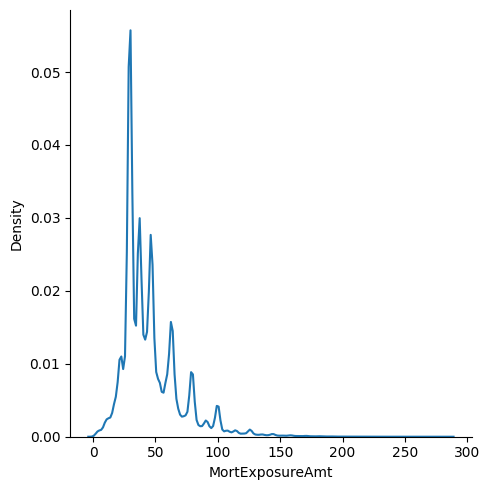

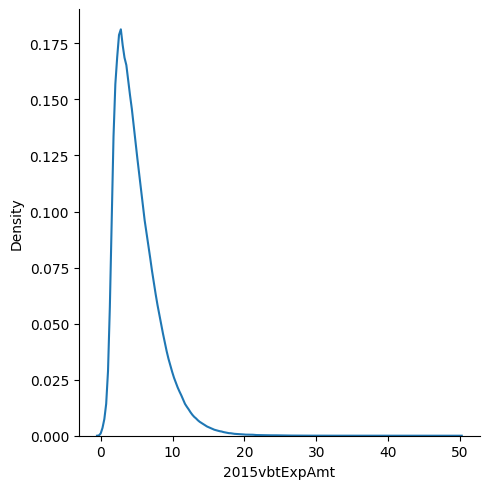

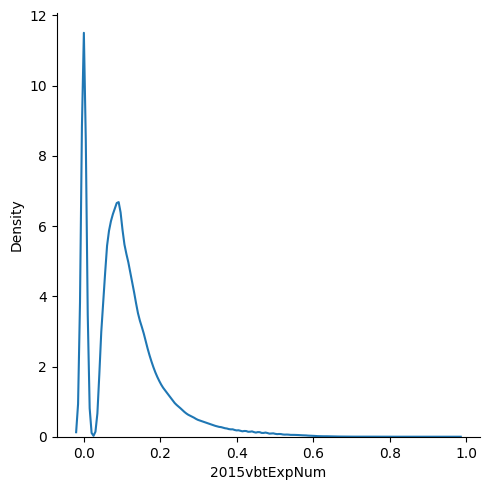

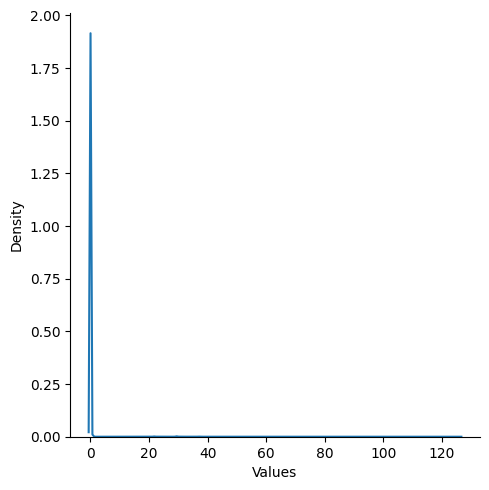

In [18]:
# Handle Outliers of 'MortExposureAmt', '2015vbtExpAmt', and '2015vbtExpNum' for Train and Test individually
# DO NOT MIX TRAIN AND TEST DATA
# MAKE SURE TO TRANSFER ALL TRANSFORMATIONS DONE TO TRAIN ONTO TEST

# Use this link for references: https://neuraldatascience.io/5-eda/data_cleaning.html


# Plot distributions
sns.displot(kind='kde',
           data=X_train,
           x='MortExposureAmt'
           )

sns.displot(kind='kde',
           data=X_train,
           x='2015vbtExpAmt'
           )

sns.displot(kind='kde',
           data=X_train,
           x='2015vbtExpNum'
           )

# Convert y_train to DF
y_temp = pd.DataFrame({'Values': y_train.reset_index(drop=True)})

sns.displot(kind='kde',
           data=y_temp,
           x= 'Values'
           )


plt.show()

#

<function matplotlib.pyplot.show(close=None, block=None)>

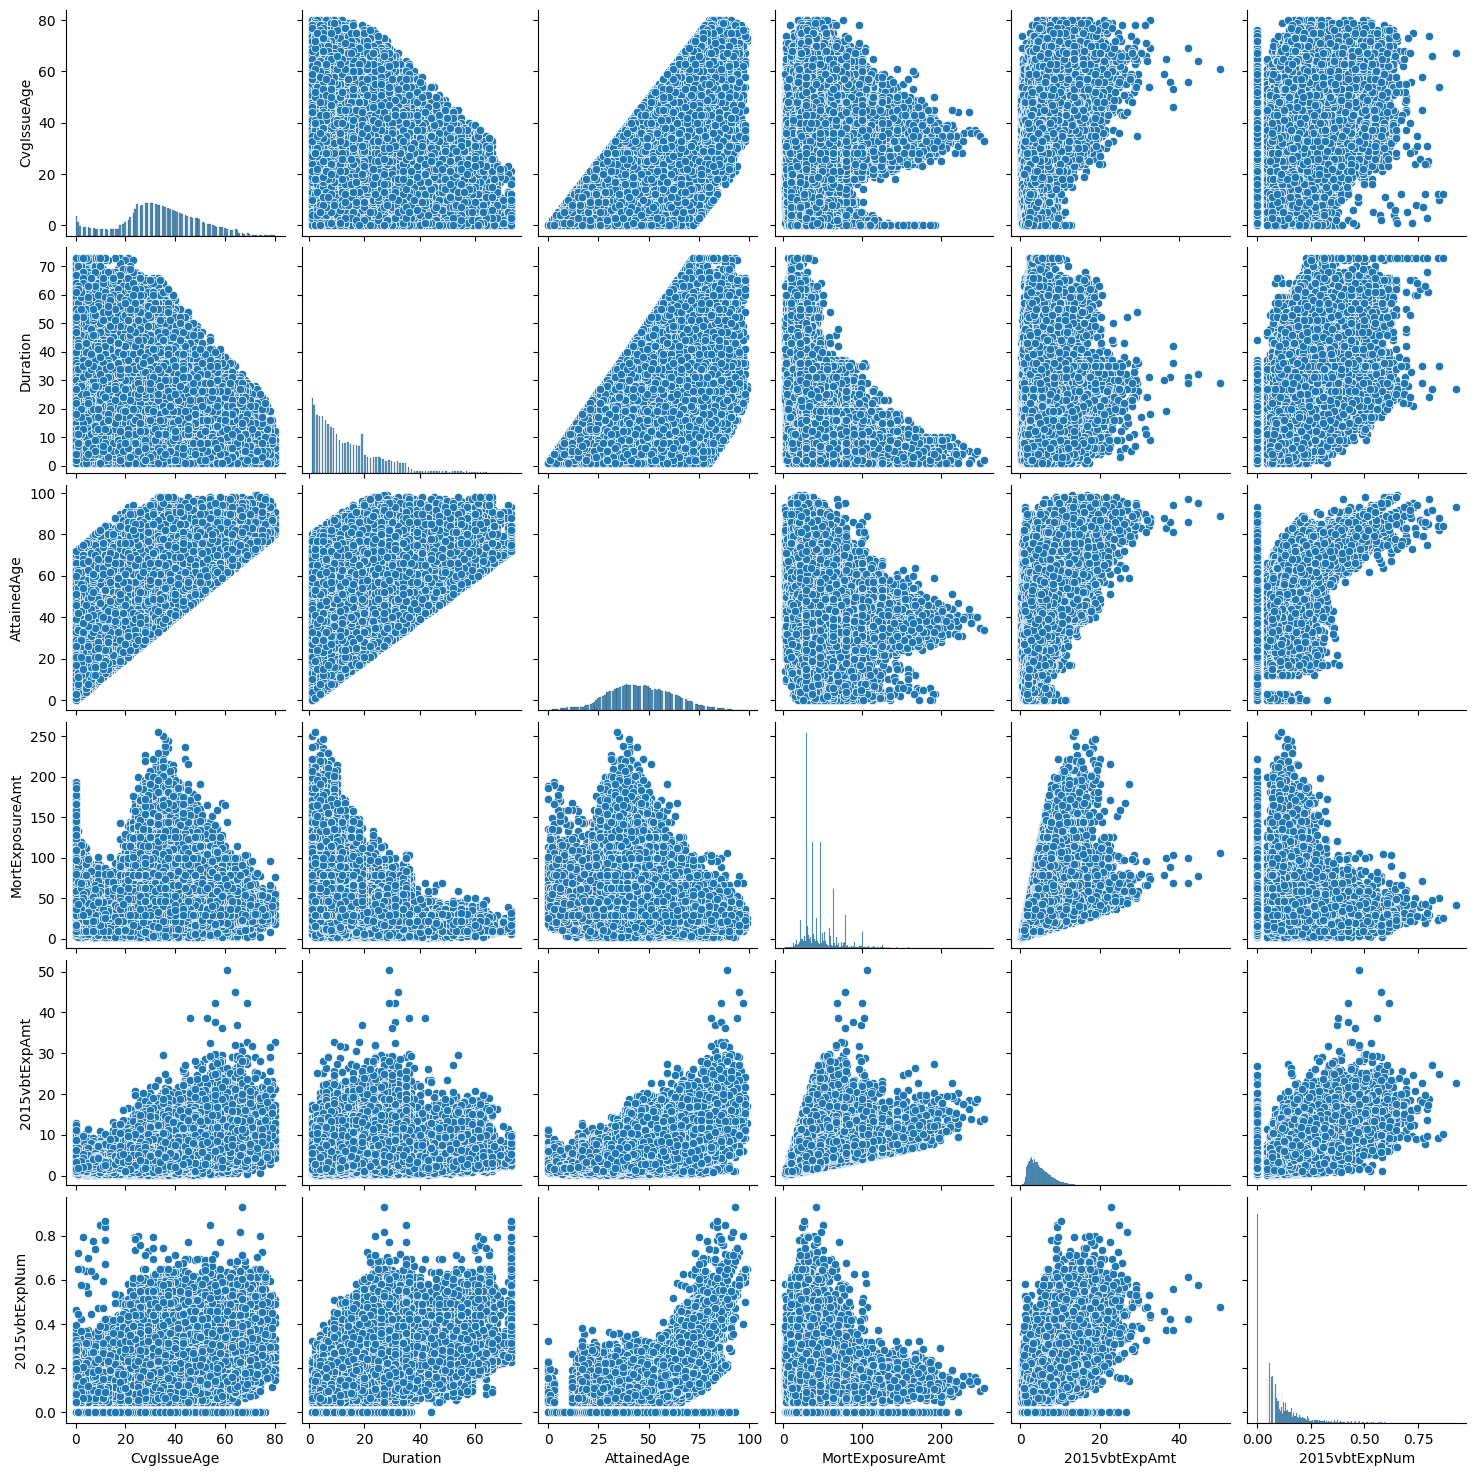

In [19]:
# Create Pairplot to check for weird Data

sns.pairplot(data=(X_test.drop(columns=['CvgSexCode','PivotTobaccoCode'])))
plt.show

In [20]:
#Calculate the range of the outliers
mea_q1 = X_train['MortExposureAmt'].quantile(0.25)
mea_q3 = X_train['MortExposureAmt'].quantile(0.75)
mea_iqr = mea_q3 - mea_q1
mea_out_low = mea_q1 - 1.5 * mea_iqr
mea_out_high = mea_q3 + 1.5 * mea_iqr

vbtAMT_q1 = X_train['2015vbtExpAmt'].quantile(0.25)
vbtAMT_q3 = X_train['2015vbtExpAmt'].quantile(0.75)
vbtAMT_iqr = vbtAMT_q3 - vbtAMT_q1
vbtAMT_out_low = vbtAMT_q1 - 1.5 * vbtAMT_iqr
vbtAMT_out_high = vbtAMT_q3 + 1.5 * vbtAMT_iqr

vbtNUM_q1 = X_train['2015vbtExpNum'].quantile(0.25)
vbtNUM_q3 = X_train['2015vbtExpNum'].quantile(0.75)
vbtNUM_iqr = vbtNUM_q3 - vbtNUM_q1
vbtNUM_out_low = vbtNUM_q1 - 1.5 * vbtNUM_iqr
vbtNUM_out_high = vbtNUM_q3 + 1.5 * vbtNUM_iqr

y_q1 = y_train.quantile(0.25)
y_q3 = y_train.quantile(0.75)
y_iqr = y_q3 - y_q1
y_out_low = y_q1 - 1.5 * y_iqr
y_out_high = y_q3 + 1.5 * y_iqr

# Convert y_train to pd.Dataframe
y_train = pd.DataFrame(y_train)

# Add outlier bool collumn for each variable
X_train['mea_outliers_tukey'] = (X_train.loc[:,'MortExposureAmt'] < mea_out_low) | (X_train.loc[:,'MortExposureAmt'] > mea_out_high)

X_train['vbtAMT_outliers_tukey'] = (X_train.loc[:,'2015vbtExpAmt'] < vbtAMT_out_low) | (X_train.loc[:,'2015vbtExpAmt'] > vbtAMT_out_high)

X_train['vbtNUM_outliers_tukey'] = (X_train.loc[:,'2015vbtExpNum'] < vbtNUM_out_low) | (X_train.loc[:,'2015vbtExpNum'] > vbtNUM_out_high)

y_train['outliers_tukey'] = (y_train < mea_out_low) | (y_train > mea_out_high)

print(X_train.head)
print()
print(y_train.head)

<bound method NDFrame.head of        CvgSexCode  CvgIssueAge  Duration  AttainedAge  MortExposureAmt  \
526161          1           27        11           37        78.024538   
543537          1           47         4           50        79.370053   
329567          0           33         9           41        36.420883   
246116          0           26         2           27        29.240177   
689089          1           47         5           51        60.822020   
...           ...          ...       ...          ...              ...   
321502          1           69        15           83        22.248983   
441633          0           35         3           37        46.530192   
677997          0           37        11           47        42.171633   
239499          1           51         2           52        29.240177   
103904          0           47        27           73        25.769913   

       PivotTobaccoCode  2015vbtExpAmt  2015vbtExpNum  mea_outliers_tukey  \
5261

In [21]:
# Add Z score collumn for each variable that required outlier ellimination

X_train['MortExposureAmt_Z'] = stats.zscore(X_train['MortExposureAmt'])
X_train['2015vbtExpAmt_Z'] = stats.zscore(X_train['2015vbtExpAmt'])
X_train['2015vbtExpNum_Z'] = stats.zscore(X_train['2015vbtExpNum'])

X_train.head()

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum,mea_outliers_tukey,vbtAMT_outliers_tukey,vbtNUM_outliers_tukey,MortExposureAmt_Z,2015vbtExpAmt_Z,2015vbtExpNum_Z
526161,1,27,11,37,78.024538,0,5.889169,0.092832,False,False,False,1.356307,0.254691,-0.201479
543537,1,47,4,50,79.370053,0,7.306144,0.088790,False,False,False,1.412920,0.719766,-0.243174
329567,0,33,9,41,36.420883,0,3.105616,0.084343,False,False,False,-0.394183,-0.658920,-0.289055
246116,0,26,2,27,29.240177,1,2.207002,0.073681,False,False,False,-0.696314,-0.953860,-0.399060
689089,1,47,5,51,60.822020,0,5.850471,0.000000,False,False,False,0.632504,0.241989,-1.159217


In [22]:
y_train['Z_values'] = stats.zscore(y_train['MortDecAmt'])
y_train

,MortDecAmt,outliers_tukey,Z_values
526161,0.0,False,-0.083437
543537,0.0,False,-0.083437
329567,0.0,False,-0.083437
246116,0.0,False,-0.083437
689089,0.0,False,-0.083437
...,...,...,...
321502,0.0,False,-0.083437
441633,0.0,False,-0.083437
677997,0.0,False,-0.083437
239499,0.0,False,-0.083437


In [23]:
# Add Collumn to check for outliers via Z score test
z_thresh = 2.5

X_train['MEA_outliers_z'] = np.abs(X_train['MortExposureAmt_Z']) > z_thresh

X_train['vbtAMT_outliers_z'] = np.abs(X_train['2015vbtExpAmt_Z']) > z_thresh

X_train['vbtNUM_outliers_z'] = np.abs(X_train['2015vbtExpNum_Z']) > z_thresh

y_train['outliers_z'] = np.abs(y_train['Z_values']) > z_thresh

<Axes: ylabel='count'>

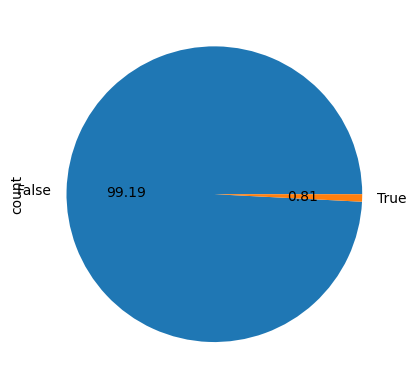

In [24]:
# Plot the ratio of Outlier to non-outliers
y_train['outliers_z'].value_counts().plot.pie(autopct = "%.2f")

In [25]:
X_train

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum,mea_outliers_tukey,vbtAMT_outliers_tukey,vbtNUM_outliers_tukey,MortExposureAmt_Z,2015vbtExpAmt_Z,2015vbtExpNum_Z,MEA_outliers_z,vbtAMT_outliers_z,vbtNUM_outliers_z
526161,1,27,11,37,78.024538,0,5.889169,0.092832,False,False,False,1.356307,0.254691,-0.201479,False,False,False
543537,1,47,4,50,79.370053,0,7.306144,0.088790,False,False,False,1.412920,0.719766,-0.243174,False,False,False
329567,0,33,9,41,36.420883,0,3.105616,0.084343,False,False,False,-0.394183,-0.658920,-0.289055,False,False,False
246116,0,26,2,27,29.240177,1,2.207002,0.073681,False,False,False,-0.696314,-0.953860,-0.399060,False,False,False
689089,1,47,5,51,60.822020,0,5.850471,0.000000,False,False,False,0.632504,0.241989,-1.159217,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321502,1,69,15,83,22.248983,0,7.645646,0.343414,False,False,True,-0.990472,0.831197,2.383761,False,False,False
441633,0,35,3,37,46.530192,1,4.283181,0.088790,False,False,False,0.031170,-0.272422,-0.243174,False,False,False
677997,0,37,11,47,42.171633,0,4.203059,0.000000,False,False,False,-0.152218,-0.298720,-1.159217,False,False,False
239499,1,51,2,52,29.240177,0,2.571282,0.084343,False,False,False,-0.696314,-0.834297,-0.289055,False,False,False


In [26]:
# Due to the data being human based It was decided that it would be best to leave the outliers in due to the imbalanced nature of the data.

# Remove outlier collumns

X_train = X_train.drop(columns=['MEA_outliers_z',
                                'vbtAMT_outliers_z',
                                'vbtNUM_outliers_z',
                                'MortExposureAmt_Z',
                                '2015vbtExpAmt_Z',
                                '2015vbtExpNum_Z',
                                'mea_outliers_tukey',
                                'vbtAMT_outliers_tukey',
                                'vbtNUM_outliers_tukey'
                                ])

y_train = y_train.drop(columns=['outliers_z',
                                'Z_values',
                                'outliers_tukey'
                                ])

X_train

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
526161,1,27,11,37,78.024538,0,5.889169,0.092832
543537,1,47,4,50,79.370053,0,7.306144,0.088790
329567,0,33,9,41,36.420883,0,3.105616,0.084343
246116,0,26,2,27,29.240177,1,2.207002,0.073681
689089,1,47,5,51,60.822020,0,5.850471,0.000000
...,...,...,...,...,...,...,...,...
321502,1,69,15,83,22.248983,0,7.645646,0.343414
441633,0,35,3,37,46.530192,1,4.283181,0.088790
677997,0,37,11,47,42.171633,0,4.203059,0.000000
239499,1,51,2,52,29.240177,0,2.571282,0.084343


In [27]:
# Create Multicollinearity Matrix
# If num > .90 , Column x Row are collinear

# Put Y infront of X variables
Xy_collin = pd.concat([y_train , X_train], axis =1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

,MortDecAmt,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
MortDecAmt,NaN,0.020825,0.059488,0.077955,0.109567,0.034322,0.001302,0.100509,0.125447
CvgSexCode,NaN,NaN,0.011128,0.026756,0.029069,0.059359,0.104003,0.175940,0.088934
CvgIssueAge,NaN,NaN,NaN,0.263092,0.733787,0.023644,0.044885,0.443751,0.324353
Duration,NaN,NaN,NaN,NaN,0.462392,0.308578,0.085931,0.259513,0.563071
AttainedAge,NaN,NaN,NaN,NaN,NaN,0.195567,0.019260,0.590576,0.694606
MortExposureAmt,NaN,NaN,NaN,NaN,NaN,NaN,0.062612,0.486613,0.163084
PivotTobaccoCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050932,0.020019
2015vbtExpAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.581702
2015vbtExpNum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

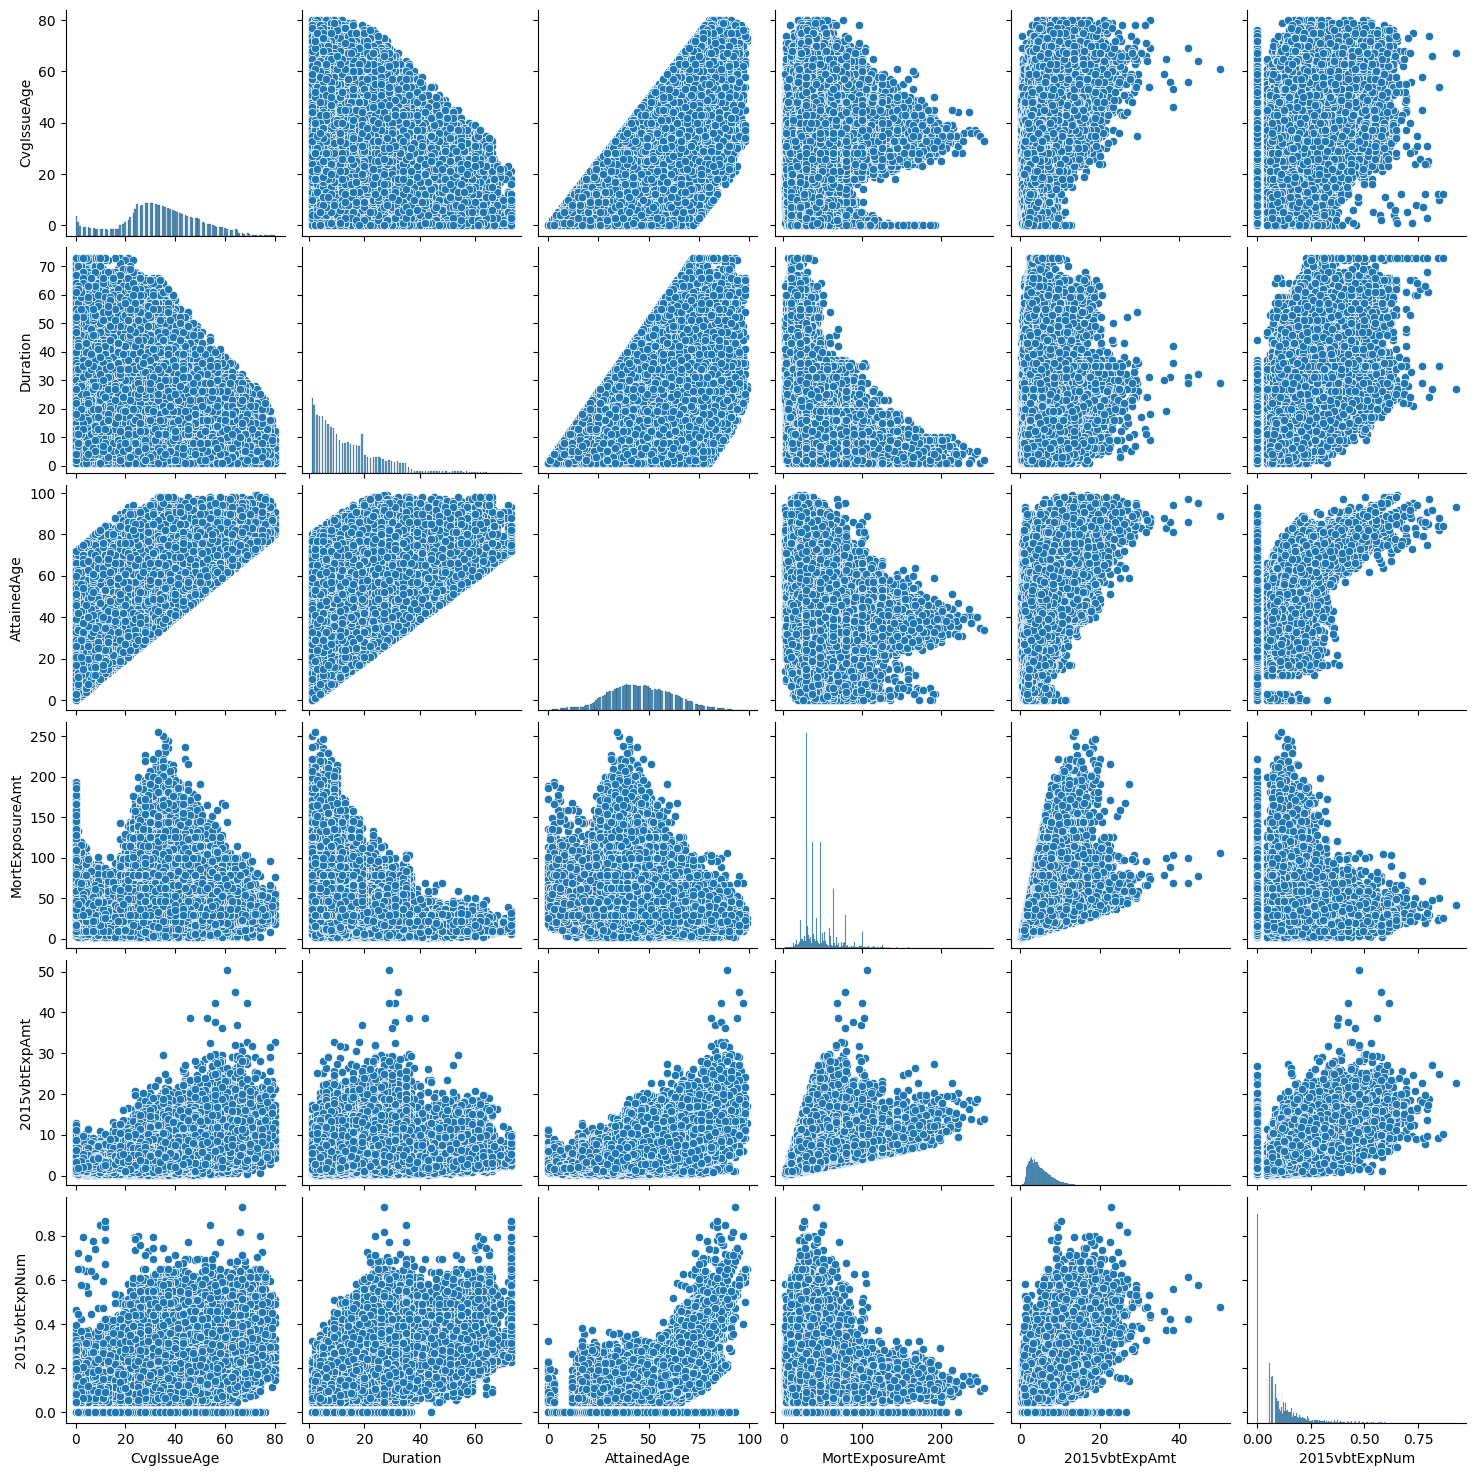

In [28]:
# Create Pairplot to check for weird Data

sns.pairplot(data=(X_test.drop(columns=['CvgSexCode','PivotTobaccoCode'])))
plt.show

In [31]:
# ----------------------  Test 1 - Histogram Gradient Boosted Trees ------------------------------------

# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

HBGT_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
HGBT_y_pred = HBGT_model.predict(X_test)

# Evaluate Model using R^2 and MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

HGBT_r2 = mean_squared_error(y_true= y_test, y_pred=HGBT_y_pred)
HGBT_MSE = r2_score(y_true= y_test, y_pred=HGBT_y_pred)

print(f'HGBT R2 Score = {HGBT_r2}')
print(f'HGBT R2 Score = {HGBT_MSE}')

c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HGBT R2 Score = 7.912038516627926
HGBT R2 Score = 0.03741760612874534


In [32]:
# -----------------------  Test 2 - MLP Regressor (Neural Network)  -----------------------------

NN_model = MLPRegressor(solver='adam',early_stopping=True)

NN_model.fit(X_train,y_train)

NN_y_pred = NN_model.predict(X_test)

NN_r2 = mean_squared_error(y_true= y_test, y_pred=NN_y_pred)
NN_MSE = r2_score(y_true= y_test, y_pred=NN_y_pred)

print(f'NN R2 Score = {NN_r2}')
print(f'NN R2 Score = {NN_MSE}')


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NN R2 Score = 7.91897285593179
NN R2 Score = 0.0365739710891787


In [33]:
# ----------------------------------  Test 3 - Random Forest Regression  -------------------------------------

RFR_model = RandomForestRegressor()

RFR_model.fit(X_train,y_train)

RFR_y_pred = RFR_model.predict(X_test)

RFR_r2 = mean_squared_error(y_true= y_test, y_pred=RFR_y_pred)
RFR_MSE = r2_score(y_true= y_test, y_pred=RFR_y_pred)

print(f'NN R2 Score = {RFR_r2}')
print(f'NN R2 Score = {RFR_MSE}')


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


NN R2 Score = 9.606478930855328
NN R2 Score = -0.16872882589018712


In [ ]:
hist_df = pd.DataFrame({})
plt.hist()